In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset,Dataset
import time
import numpy as np
import matplotlib.pyplot as plt
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Net(nn.Module):
    def __init__(self , model):	#此处的model参数是已经加载了预训练参数的模型，方便继承预训练成果
        super(Net, self).__init__()
        #取掉model的后两层
        self.resnet_layer = nn.Sequential(*list(model.children())[:-2])
        self.dr_layer1=nn.modules.conv.Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn1=nn.modules.batchnorm.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer2=nn.modules.conv.Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn2=nn.modules.batchnorm.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer3=nn.modules.conv.Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.dr_bn3=nn.modules.batchnorm.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.dr_layer4=nn.modules.conv.Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

        
    def forward(self, x):
        x = self.resnet_layer(x)
        x=self.dr_layer1(x)
        x=self.dr_bn1(x)
        x=self.dr_layer2(x)
        x=self.dr_bn2(x)
        x=self.dr_layer3(x)
        x=self.dr_bn3(x)
        x=self.dr_layer4(x)
        return x

In [3]:
resnet50 = models.resnet50(pretrained=True)
resnet50.conv1=nn.modules.conv.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model = Net(resnet50) 
model=model.to(device)
# print(model)

In [4]:
shapeness1=np.load('/home/chase/Boyka/Lyu/data/shapeness/origin/rainfall_img256_sharpness1_unit8.npz')
data=shapeness1['data'][:,-1]
label=shapeness1['rainfall']
# data=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/data_reg_2000.npy')
data=np.expand_dims(data,axis=1)
# data=torch.from_numpy(data)
data=torch.FloatTensor(data)
# print(type(data[0][0][0]))
# print(data[0][0][0])
# label=np.load('/home/chase/Boyka/Lyu/data/rainfall/reg/label_reg_2000.npy')
print(label.shape)
label=np.expand_dims(label,axis=1)
# label=torch.from_numpy(label)
label=torch.FloatTensor(label)
# print(label[0][0][0])
# print(data.shape,label.shape)
train_x=data[:-20]
test_x=data[-20:]
train_y=label[:-20]
test_y=label[-20:]
print(data.shape,label.shape)

(100, 8, 8)
torch.Size([100, 1, 256, 256]) torch.Size([100, 1, 8, 8])


In [5]:
train_dataset = TensorDataset(train_x,train_y)
test_dataset = TensorDataset(test_x,test_y)
train_loader=DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,num_workers=2)
test_loader=DataLoader(dataset=test_dataset,batch_size=32,shuffle=True,num_workers=2)
train_data_size=len(train_loader)
valid_data_size=len(test_loader)

In [6]:
for epoch in range(1):
    for i,data in enumerate(train_loader):
        inputs, label=data
#         print("epoch：", epoch, "的第" , i, "个inputs", inputs.data.size(), "labels", labels.data.size())
        print(len(data))
        print(data[0].shape)
        print(inputs.shape)
        print(label.shape)
        print(type(data[0][0][0][0]))
        break
        
        

2
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 8, 8])
<class 'torch.Tensor'>


In [7]:
def train_and_valid(model, loss_function, optimizer, epochs=25):
    
    history = []
    best_error = float('inf')
    best_epoch = 0
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        model.train()
        train_loss = 0.0
        train_error = 0.0
        valid_loss = 0.0
        valid_error = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += torch.mean(loss).item() 
            
            train_error+=torch.mean(torch.abs(outputs-labels)).item()
 
        with torch.no_grad():
            model.eval()
            for j, (inputs, labels) in enumerate(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                valid_loss += torch.mean(loss).item() 
                
                valid_error+=torch.mean(torch.abs(outputs-labels)).item()
 
 
        avg_train_loss = train_loss/train_data_size
        avg_train_error = train_error/train_data_size
 
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_error = valid_error/valid_data_size
 
        history.append([avg_train_loss, avg_valid_loss, avg_train_error, avg_valid_error])
 
        if best_error > avg_valid_error:
            best_error = avg_valid_error
            best_epoch = epoch + 1
 
        epoch_end = time.time()
 
        print("Training: Loss: {:.4f}, MAE: {:.4f}, \nValidation: Loss: {:.4f}, MAE: {:.4f}, \nTime: {:.4f}s".format(avg_train_loss, avg_train_error, avg_valid_loss, avg_valid_error, epoch_end-epoch_start
        ))
        print("Best Error for validation : {:.4f} at epoch {:03d}".format(best_error, best_epoch))
        if epoch%20==0:
            torch.save(model, 'models/'+'rivers_model_'+str(epoch+1)+'.pt')
    return model, history


In [8]:
loss_func=nn.MSELoss()
num_epochs=500
optimizer = optim.Adam(model.parameters())


trained_model, history = train_and_valid(model, loss_func, optimizer, num_epochs)
torch.save(trained_model, 'models/'+'best_model.pt')
 


Epoch: 1/500


/home/chase/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: Loss: 0.6242, MAE: 0.6366, 
Validation: Loss: 0.5383, MAE: 0.6621, 
Time: 1.0658s
Best Error for validation : 0.6621 at epoch 001
Epoch: 2/500
Training: Loss: 0.3427, MAE: 0.5067, 
Validation: Loss: 0.4170, MAE: 0.5740, 
Time: 1.0721s
Best Error for validation : 0.5740 at epoch 002
Epoch: 3/500
Training: Loss: 0.3201, MAE: 0.4905, 
Validation: Loss: 0.4826, MAE: 0.6243, 
Time: 1.0644s
Best Error for validation : 0.5740 at epoch 002
Epoch: 4/500
Training: Loss: 0.3138, MAE: 0.4844, 
Validation: Loss: 1.8265, MAE: 1.1467, 
Time: 1.0712s
Best Error for validation : 0.5740 at epoch 002
Epoch: 5/500
Training: Loss: 0.3118, MAE: 0.4829, 
Validation: Loss: 2.5659, MAE: 1.3468, 
Time: 1.0711s
Best Error for validation : 0.5740 at epoch 002
Epoch: 6/500
Training: Loss: 0.3059, MAE: 0.4769, 
Validation: Loss: 1.7650, MAE: 1.1617, 
Time: 1.0759s
Best Error for validation : 0.5740 at epoch 002
Epoch: 7/500
Training: Loss: 0.3018, MAE: 0.4734, 
Validation: Loss: 1.1563, MAE: 0.9620, 
Time

Training: Loss: 0.0289, MAE: 0.1680, 
Validation: Loss: 0.0653, MAE: 0.2072, 
Time: 1.0689s
Best Error for validation : 0.2072 at epoch 055
Epoch: 56/500
Training: Loss: 0.0259, MAE: 0.1590, 
Validation: Loss: 0.0644, MAE: 0.2111, 
Time: 1.0688s
Best Error for validation : 0.2072 at epoch 055
Epoch: 57/500
Training: Loss: 0.0244, MAE: 0.1535, 
Validation: Loss: 0.0600, MAE: 0.1985, 
Time: 1.0674s
Best Error for validation : 0.1985 at epoch 057
Epoch: 58/500
Training: Loss: 0.0222, MAE: 0.1463, 
Validation: Loss: 0.0607, MAE: 0.2006, 
Time: 1.0696s
Best Error for validation : 0.1985 at epoch 057
Epoch: 59/500
Training: Loss: 0.0195, MAE: 0.1369, 
Validation: Loss: 0.0583, MAE: 0.1947, 
Time: 1.0666s
Best Error for validation : 0.1947 at epoch 059
Epoch: 60/500
Training: Loss: 0.0185, MAE: 0.1330, 
Validation: Loss: 0.0571, MAE: 0.1921, 
Time: 1.0632s
Best Error for validation : 0.1921 at epoch 060
Epoch: 61/500
Training: Loss: 0.0168, MAE: 0.1264, 
Validation: Loss: 0.0563, MAE: 0.1920,

Training: Loss: 0.0005, MAE: 0.0159, 
Validation: Loss: 0.0359, MAE: 0.1427, 
Time: 1.0706s
Best Error for validation : 0.1421 at epoch 105
Epoch: 110/500
Training: Loss: 0.0006, MAE: 0.0178, 
Validation: Loss: 0.0367, MAE: 0.1433, 
Time: 1.0781s
Best Error for validation : 0.1421 at epoch 105
Epoch: 111/500
Training: Loss: 0.0009, MAE: 0.0241, 
Validation: Loss: 0.0367, MAE: 0.1457, 
Time: 1.0795s
Best Error for validation : 0.1421 at epoch 105
Epoch: 112/500
Training: Loss: 0.0011, MAE: 0.0231, 
Validation: Loss: 0.0376, MAE: 0.1451, 
Time: 1.0731s
Best Error for validation : 0.1421 at epoch 105
Epoch: 113/500
Training: Loss: 0.0011, MAE: 0.0243, 
Validation: Loss: 0.0367, MAE: 0.1460, 
Time: 1.0733s
Best Error for validation : 0.1421 at epoch 105
Epoch: 114/500
Training: Loss: 0.0008, MAE: 0.0210, 
Validation: Loss: 0.0364, MAE: 0.1424, 
Time: 1.0721s
Best Error for validation : 0.1421 at epoch 105
Epoch: 115/500
Training: Loss: 0.0011, MAE: 0.0202, 
Validation: Loss: 0.0357, MAE: 0

Epoch: 162/500
Training: Loss: 0.0002, MAE: 0.0116, 
Validation: Loss: 0.0366, MAE: 0.1434, 
Time: 1.0770s
Best Error for validation : 0.1398 at epoch 123
Epoch: 163/500
Training: Loss: 0.0003, MAE: 0.0131, 
Validation: Loss: 0.0344, MAE: 0.1396, 
Time: 1.0750s
Best Error for validation : 0.1396 at epoch 163
Epoch: 164/500
Training: Loss: 0.0005, MAE: 0.0164, 
Validation: Loss: 0.0366, MAE: 0.1441, 
Time: 1.0801s
Best Error for validation : 0.1396 at epoch 163
Epoch: 165/500
Training: Loss: 0.0004, MAE: 0.0141, 
Validation: Loss: 0.0347, MAE: 0.1401, 
Time: 1.1695s
Best Error for validation : 0.1396 at epoch 163
Epoch: 166/500
Training: Loss: 0.0004, MAE: 0.0148, 
Validation: Loss: 0.0370, MAE: 0.1443, 
Time: 1.0726s
Best Error for validation : 0.1396 at epoch 163
Epoch: 167/500
Training: Loss: 0.0005, MAE: 0.0153, 
Validation: Loss: 0.0346, MAE: 0.1399, 
Time: 1.0697s
Best Error for validation : 0.1396 at epoch 163
Epoch: 168/500
Training: Loss: 0.0003, MAE: 0.0122, 
Validation: Loss:

Training: Loss: 0.0002, MAE: 0.0098, 
Validation: Loss: 0.0349, MAE: 0.1409, 
Time: 1.0821s
Best Error for validation : 0.1388 at epoch 196
Epoch: 216/500
Training: Loss: 0.0003, MAE: 0.0143, 
Validation: Loss: 0.0349, MAE: 0.1408, 
Time: 1.0837s
Best Error for validation : 0.1388 at epoch 196
Epoch: 217/500
Training: Loss: 0.0002, MAE: 0.0095, 
Validation: Loss: 0.0348, MAE: 0.1404, 
Time: 1.0875s
Best Error for validation : 0.1388 at epoch 196
Epoch: 218/500
Training: Loss: 0.0002, MAE: 0.0097, 
Validation: Loss: 0.0349, MAE: 0.1411, 
Time: 1.0838s
Best Error for validation : 0.1388 at epoch 196
Epoch: 219/500
Training: Loss: 0.0002, MAE: 0.0105, 
Validation: Loss: 0.0346, MAE: 0.1405, 
Time: 1.0861s
Best Error for validation : 0.1388 at epoch 196
Epoch: 220/500
Training: Loss: 0.0002, MAE: 0.0124, 
Validation: Loss: 0.0349, MAE: 0.1405, 
Time: 1.0801s
Best Error for validation : 0.1388 at epoch 196
Epoch: 221/500
Training: Loss: 0.0003, MAE: 0.0121, 
Validation: Loss: 0.0356, MAE: 0

Training: Loss: 0.0002, MAE: 0.0112, 
Validation: Loss: 0.0345, MAE: 0.1405, 
Time: 1.0804s
Best Error for validation : 0.1388 at epoch 196
Epoch: 269/500
Training: Loss: 0.0002, MAE: 0.0112, 
Validation: Loss: 0.0345, MAE: 0.1398, 
Time: 1.0799s
Best Error for validation : 0.1388 at epoch 196
Epoch: 270/500
Training: Loss: 0.0001, MAE: 0.0089, 
Validation: Loss: 0.0343, MAE: 0.1400, 
Time: 1.1072s
Best Error for validation : 0.1388 at epoch 196
Epoch: 271/500
Training: Loss: 0.0002, MAE: 0.0098, 
Validation: Loss: 0.0346, MAE: 0.1404, 
Time: 1.0841s
Best Error for validation : 0.1388 at epoch 196
Epoch: 272/500
Training: Loss: 0.0002, MAE: 0.0116, 
Validation: Loss: 0.0344, MAE: 0.1398, 
Time: 1.0902s
Best Error for validation : 0.1388 at epoch 196
Epoch: 273/500
Training: Loss: 0.0001, MAE: 0.0088, 
Validation: Loss: 0.0345, MAE: 0.1403, 
Time: 1.0842s
Best Error for validation : 0.1388 at epoch 196
Epoch: 274/500
Training: Loss: 0.0001, MAE: 0.0085, 
Validation: Loss: 0.0342, MAE: 0

Training: Loss: 0.0001, MAE: 0.0086, 
Validation: Loss: 0.0347, MAE: 0.1408, 
Time: 1.0680s
Best Error for validation : 0.1388 at epoch 196
Epoch: 322/500
Training: Loss: 0.0001, MAE: 0.0083, 
Validation: Loss: 0.0344, MAE: 0.1403, 
Time: 1.1848s
Best Error for validation : 0.1388 at epoch 196
Epoch: 323/500
Training: Loss: 0.0001, MAE: 0.0093, 
Validation: Loss: 0.0341, MAE: 0.1400, 
Time: 1.0659s
Best Error for validation : 0.1388 at epoch 196
Epoch: 324/500
Training: Loss: 0.0002, MAE: 0.0106, 
Validation: Loss: 0.0347, MAE: 0.1408, 
Time: 1.0699s
Best Error for validation : 0.1388 at epoch 196
Epoch: 325/500
Training: Loss: 0.0002, MAE: 0.0114, 
Validation: Loss: 0.0341, MAE: 0.1403, 
Time: 1.0714s
Best Error for validation : 0.1388 at epoch 196
Epoch: 326/500
Training: Loss: 0.0002, MAE: 0.0097, 
Validation: Loss: 0.0345, MAE: 0.1405, 
Time: 1.0752s
Best Error for validation : 0.1388 at epoch 196
Epoch: 327/500
Training: Loss: 0.0002, MAE: 0.0099, 
Validation: Loss: 0.0337, MAE: 0

Training: Loss: 0.0002, MAE: 0.0095, 
Validation: Loss: 0.0340, MAE: 0.1399, 
Time: 1.0702s
Best Error for validation : 0.1385 at epoch 329
Epoch: 375/500
Training: Loss: 0.0002, MAE: 0.0109, 
Validation: Loss: 0.0339, MAE: 0.1398, 
Time: 1.0717s
Best Error for validation : 0.1385 at epoch 329
Epoch: 376/500
Training: Loss: 0.0001, MAE: 0.0084, 
Validation: Loss: 0.0340, MAE: 0.1393, 
Time: 1.0728s
Best Error for validation : 0.1385 at epoch 329
Epoch: 377/500
Training: Loss: 0.0001, MAE: 0.0089, 
Validation: Loss: 0.0339, MAE: 0.1396, 
Time: 1.0621s
Best Error for validation : 0.1385 at epoch 329
Epoch: 378/500
Training: Loss: 0.0003, MAE: 0.0133, 
Validation: Loss: 0.0343, MAE: 0.1400, 
Time: 1.0736s
Best Error for validation : 0.1385 at epoch 329
Epoch: 379/500
Training: Loss: 0.0001, MAE: 0.0093, 
Validation: Loss: 0.0336, MAE: 0.1391, 
Time: 1.0696s
Best Error for validation : 0.1385 at epoch 329
Epoch: 380/500
Training: Loss: 0.0001, MAE: 0.0089, 
Validation: Loss: 0.0344, MAE: 0

Training: Loss: 0.0001, MAE: 0.0079, 
Validation: Loss: 0.0343, MAE: 0.1403, 
Time: 1.0693s
Best Error for validation : 0.1382 at epoch 424
Epoch: 428/500
Training: Loss: 0.0002, MAE: 0.0114, 
Validation: Loss: 0.0339, MAE: 0.1393, 
Time: 1.0707s
Best Error for validation : 0.1382 at epoch 424
Epoch: 429/500
Training: Loss: 0.0002, MAE: 0.0097, 
Validation: Loss: 0.0339, MAE: 0.1395, 
Time: 1.0656s
Best Error for validation : 0.1382 at epoch 424
Epoch: 430/500
Training: Loss: 0.0001, MAE: 0.0089, 
Validation: Loss: 0.0342, MAE: 0.1397, 
Time: 1.0699s
Best Error for validation : 0.1382 at epoch 424
Epoch: 431/500
Training: Loss: 0.0001, MAE: 0.0093, 
Validation: Loss: 0.0336, MAE: 0.1391, 
Time: 1.0703s
Best Error for validation : 0.1382 at epoch 424
Epoch: 432/500
Training: Loss: 0.0002, MAE: 0.0109, 
Validation: Loss: 0.0344, MAE: 0.1400, 
Time: 1.0743s
Best Error for validation : 0.1382 at epoch 424
Epoch: 433/500
Training: Loss: 0.0002, MAE: 0.0100, 
Validation: Loss: 0.0333, MAE: 0

Training: Loss: 0.0001, MAE: 0.0084, 
Validation: Loss: 0.0332, MAE: 0.1377, 
Time: 1.0656s
Best Error for validation : 0.1377 at epoch 480
Epoch: 481/500
Training: Loss: 0.0002, MAE: 0.0112, 
Validation: Loss: 0.0342, MAE: 0.1404, 
Time: 1.0694s
Best Error for validation : 0.1377 at epoch 480
Epoch: 482/500
Training: Loss: 0.0001, MAE: 0.0094, 
Validation: Loss: 0.0334, MAE: 0.1383, 
Time: 1.0710s
Best Error for validation : 0.1377 at epoch 480
Epoch: 483/500
Training: Loss: 0.0001, MAE: 0.0084, 
Validation: Loss: 0.0341, MAE: 0.1404, 
Time: 1.0684s
Best Error for validation : 0.1377 at epoch 480
Epoch: 484/500
Training: Loss: 0.0001, MAE: 0.0084, 
Validation: Loss: 0.0333, MAE: 0.1382, 
Time: 1.0698s
Best Error for validation : 0.1377 at epoch 480
Epoch: 485/500
Training: Loss: 0.0001, MAE: 0.0081, 
Validation: Loss: 0.0343, MAE: 0.1404, 
Time: 1.0692s
Best Error for validation : 0.1377 at epoch 480
Epoch: 486/500
Training: Loss: 0.0002, MAE: 0.0099, 
Validation: Loss: 0.0334, MAE: 0

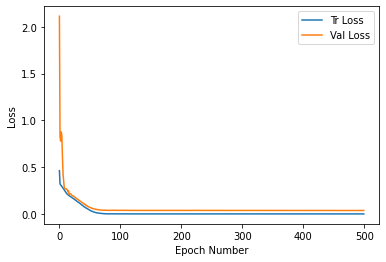

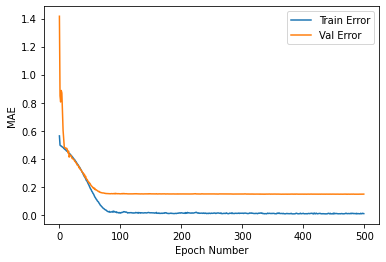

In [19]:
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.savefig('loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Train Error', 'Val Error'])
plt.xlabel('Epoch Number')
plt.ylabel('MAE')
# plt.ylim(0, 1)
plt.savefig('error_curve.png')
plt.show()

In [19]:
test_x[0].shape
test_sample=torch.unsqueeze(test_x[0],0).to(device)

In [24]:
result=model(test_sample)
result

tensor([[[[0.5631, 0.1613, 0.2831, 0.1240, 0.8366, 0.5690, 0.7362, 0.4886],
          [0.0742, 0.9606, 0.4491, 0.4479, 0.6530, 0.5563, 0.1661, 0.4700],
          [0.5010, 0.6659, 0.5144, 0.3786, 0.7997, 0.0676, 0.6715, 0.7638],
          [0.0919, 0.0576, 0.5811, 0.3686, 0.8451, 0.2421, 0.0748, 0.8471],
          [0.6665, 0.0609, 0.0922, 0.0808, 0.6040, 0.8294, 0.3668, 0.0388],
          [0.8125, 0.7152, 0.5228, 0.8383, 0.3344, 0.7030, 0.4074, 0.5135],
          [0.6818, 0.2215, 0.6831, 0.5449, 0.5332, 0.6988, 0.5042, 0.5323],
          [0.2559, 0.6910, 0.2404, 0.8101, 0.6730, 0.6057, 0.1841, 0.7367]]]],
       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)

In [26]:
result_sample=torch.unsqueeze(test_y[0],0).to(device)

In [27]:
result_sample

tensor([[[[0.6125, 0.1979, 0.2406, 0.1793, 0.8570, 0.5676, 0.6852, 0.4797],
          [0.0252, 0.9620, 0.4662, 0.4342, 0.5943, 0.5465, 0.0063, 0.4676],
          [0.3534, 0.7350, 0.4841, 0.4371, 0.8043, 0.1661, 0.6479, 0.6845],
          [0.0677, 0.0090, 0.5210, 0.4059, 0.7147, 0.2345, 0.0966, 0.7759],
          [0.5437, 0.2324, 0.0677, 0.1109, 0.7154, 0.7373, 0.4614, 0.0300],
          [0.8700, 0.7075, 0.4881, 0.9723, 0.4534, 0.6483, 0.3494, 0.5438],
          [0.6012, 0.1513, 0.7136, 0.3365, 0.5521, 0.9445, 0.4872, 0.5929],
          [0.2073, 0.6932, 0.2435, 0.9906, 0.8046, 0.4374, 0.2315, 0.7283]]]],
       device='cuda:0')

In [28]:
result_sample-result

tensor([[[[ 0.0495,  0.0366, -0.0426,  0.0553,  0.0203, -0.0014, -0.0511,
           -0.0089],
          [-0.0490,  0.0014,  0.0172, -0.0137, -0.0586, -0.0098, -0.1598,
           -0.0024],
          [-0.1476,  0.0691, -0.0304,  0.0585,  0.0046,  0.0985, -0.0235,
           -0.0793],
          [-0.0242, -0.0486, -0.0601,  0.0373, -0.1304, -0.0076,  0.0218,
           -0.0712],
          [-0.1228,  0.1716, -0.0245,  0.0301,  0.1114, -0.0922,  0.0946,
           -0.0089],
          [ 0.0575, -0.0077, -0.0346,  0.1340,  0.1190, -0.0547, -0.0580,
            0.0302],
          [-0.0806, -0.0702,  0.0305, -0.2084,  0.0189,  0.2457, -0.0170,
            0.0606],
          [-0.0486,  0.0022,  0.0031,  0.1805,  0.1316, -0.1683,  0.0474,
           -0.0084]]]], device='cuda:0', grad_fn=<SubBackward0>)

In [29]:
history[-1]

array([9.16668803e-05, 1.10731925e-02, 7.42801220e-03, 7.17941964e-02])